In [2]:
import wrds, datetime
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

pd.options.mode.chained_assignment = None  # default='warn'

conn = wrds.Connection()

/Users/armanozcan/anaconda3/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


Loading library list...
Done


# DATA COLLECTION

## SNP , RFR , Trading Days

In [3]:
query_start_date = '1990-01-01'

In [4]:
sp500_data = conn.raw_sql(f"""
SELECT
    caldt AS date,
    sprtrn AS snp_daily_return -- Equal-Weighted Return (includes distributions) (ewretd)
FROM
    crspq.dsp500
WHERE
    caldt >= '{query_start_date}'
ORDER BY
    caldt;
""")
sp500_data['date'] = pd.to_datetime(sp500_data['date'])

sp500_data

,date,snp_daily_return
0,1990-01-02,0.017799
1,1990-01-03,-0.002586
2,1990-01-04,-0.008613
3,1990-01-05,-0.009756
4,1990-01-08,0.004514
...,...,...
8748,2024-09-24,0.002511
8749,2024-09-25,-0.001861
8750,2024-09-26,0.004039
8751,2024-09-27,-0.001253


In [5]:
risk_free_data = conn.raw_sql(f'''
    SELECT
        date,
        rf AS daily_rf_rate -- One Month Treasury Bill Rate (daily)
    FROM
        ff.factors_daily
    WHERE
        date >= '{query_start_date}'
''')

risk_free_data['date'] = pd.to_datetime(risk_free_data['date'])

risk_free_data

,date,daily_rf_rate
0,1990-01-02,0.00026
1,1990-01-03,0.00026
2,1990-01-04,0.00026
3,1990-01-05,0.00026
4,1990-01-08,0.00026
...,...,...
8771,2024-10-25,0.00017
8772,2024-10-28,0.00017
8773,2024-10-29,0.00017
8774,2024-10-30,0.00017


In [6]:
last_trading_days = conn.raw_sql(f'''
SELECT DISTINCT
    MAX(date) AS last_trade_date
FROM crsp.dsf
WHERE date >= '{query_start_date}'
GROUP BY DATE_TRUNC('month', date)
ORDER BY last_trade_date
''')

last_trading_days['last_trade_date'] = pd.to_datetime(last_trading_days['last_trade_date'])
last_trading_days['month'] = last_trading_days['last_trade_date'].dt.month
last_trading_days['year'] = last_trading_days['last_trade_date'].dt.year
last_trading_day_mapping = last_trading_days.set_index(['year', 'month'])['last_trade_date'].to_dict()

In [7]:
last_trading_days

,last_trade_date,month,year
0,1990-01-31,1,1990
1,1990-02-28,2,1990
2,1990-03-30,3,1990
3,1990-04-30,4,1990
4,1990-05-31,5,1990
...,...,...,...
403,2023-08-31,8,2023
404,2023-09-29,9,2023
405,2023-10-31,10,2023
406,2023-11-30,11,2023


## Query Company Data

In [8]:
def get_company_financials(gvkey):
    company_fin_data = conn.raw_sql(f'''
    SELECT
        datadate AS date,
        gvkey AS gvkey,
        rdq AS reporting_date, -- Date of which information was reported
        atq AS total_assets,  -- Total Assets
        chq AS cash_holdings,  -- Cash and Short-Term Investments
        dlttq + dlcq AS total_debt,  -- Total Debt (long-term + short-term debt)
        ibq AS earnings,  -- Earnings before extraordinary items
        xrdq AS rd_expense,  -- R&D expense
        dvpq AS dividends_paid,  -- Dividends paid
        xintq AS interest_expense  -- Interest expense
    FROM
        comp.fundq
    WHERE
        gvkey = '{gvkey}'
        AND datadate >= '{query_start_date}'  -- Ensure data is after the link start date
    ''')
    
    company_fin_data['date'] = pd.to_datetime(company_fin_data['date'])
    company_fin_data['reporting_date'] = pd.to_datetime(company_fin_data['reporting_date'])
    
    return company_fin_data.dropna()

In [9]:
def make_PiT_ffill(company_fin_data):

    temp = company_fin_data.copy()
    
    #company_fin_data['month_start'] = company_fin_data['date'] - pd.offsets.MonthBegin()
    #company_fin_data['month_end'] = company_fin_data['date']

    temp['reporting_date'] = pd.to_datetime(temp['reporting_date']) + pd.Timedelta(days=1)
    temp['month'] = temp['reporting_date'].dt.month
    temp['year'] = temp['reporting_date'].dt.year
    
    temp['EOM_trade_date'] = temp.apply(
        lambda row: last_trading_day_mapping.get((row['year'], row['month'])),
        axis=1
    )
    temp.drop(columns=['date','month','year','reporting_date'], axis=1, inplace=True)
    temp.rename(columns={'EOM_trade_date':'date'}, inplace=True)
    temp = temp[temp.columns[-1:].append(temp.columns[:-1])]
    temp['date'] = pd.to_datetime(temp['date'])

    start_date = temp['date'].min()
    end_date = temp['date'].max()

    if pd.isnull(start_date) or pd.isnull(end_date): # return empty tables for companies that have broken data
        print("Date Error for GVKEY: ", temp['gvkey'][0])
        return pd.DataFrame({"date":[]})

    all_months = pd.date_range(start=start_date, end=end_date, freq='ME')
    full_range_df = pd.DataFrame({'date': all_months})

    temp = pd.merge(full_range_df, temp, on='date', how='left')

    temp = temp.ffill()

    temp['month_start'] = temp['date'] - pd.offsets.MonthBegin()
    temp['month_end'] = temp['date']

    return temp

In [10]:
def get_prices(permno):
    company_stock_prcs = conn.raw_sql(f'''
    SELECT
        permno,
        date,
        ret AS taken_stock_return,
        prc AS stock_price,
        ABS(prc * shrout) AS market_cap  -- Market cap
    FROM
        crsp.dsf
    WHERE
        permno = {permno}
    ''')
    
    company_stock_prcs['date'] = pd.to_datetime(company_stock_prcs['date'])

    return company_stock_prcs

In [11]:
def get_comp_data(permno, gvkey):
    # Load financial data and stock price data
    company_fin_data = make_PiT_ffill(get_company_financials(gvkey))
    company_stock_prcs = get_prices(permno)

    # Calculate monthly cumulative return using taken_stock_return
    def calculate_monthly_cumulative_returns(fin_data, stock_data):
        monthly_returns = []
        for _, row in fin_data.iterrows():
            # Filter stock data for the current month's start and end dates
            mask = (stock_data['date'] >= row['month_start']) & (stock_data['date'] <= row['month_end'])
            relevant_data = stock_data.loc[mask]

            # Compute cumulative return: (1 + taken_stock_return).prod() - 1
            if not relevant_data.empty:
                cumulative_return = (1 + relevant_data['taken_stock_return']).prod() - 1
            else:
                cumulative_return = None  # No data for this month
            monthly_returns.append(cumulative_return)
        return monthly_returns

    # Compute monthly cumulative returns
    company_fin_data['stock_return'] = calculate_monthly_cumulative_returns(company_fin_data, company_stock_prcs)

    # Merge the financial data with stock data for other columns if necessary
    company = pd.merge(company_fin_data, company_stock_prcs, on='date', how='left').interpolate().ffill()
    # drop taken_stock_return column
    company.drop(columns=['taken_stock_return'], inplace=True)

    return company

# Calculate Cash Hedged Returns

In [12]:
def calculate_b_it(company):
    data = company.copy()
    data['market_cap_t_minus_1'] = data['market_cap'].shift() # paper uses M_{t-1} for the denoms
    data['leverage'] = data['total_debt'] / (data['total_debt'] + data['market_cap'])
    
    # Y VALUES
    data['r_minus_R'] = data['stock_return'] - data['rf_rate']
    
    # REGRESSION VARIABLES
    data['gamma_1'] = (data['cash_holdings'].diff()) / data['market_cap_t_minus_1']
    data['gamma_2'] = (data['earnings'].diff()) / data['market_cap_t_minus_1']
    data['gamma_3'] = ((data['total_assets'] - data['cash_holdings']).diff()) / data['market_cap_t_minus_1']
    data['gamma_4'] = (data['rd_expense'].diff()) / data['market_cap_t_minus_1']
    data['gamma_5'] = (data['interest_expense'].diff()) / data['market_cap_t_minus_1']
    data['gamma_6'] = (data['dividends_paid'].diff()) / data['market_cap_t_minus_1']
    data['gamma_7']= data['cash_holdings_t_minus_1'] / data['market_cap_t_minus_1']
    data['gamma_8'] = data['leverage']
    data['gamma_9'] = (data['total_debt'].diff() + data['market_cap_t_minus_1'].diff()) / (data['total_debt'].shift() + data['market_cap_t_minus_1'].shift())
    data['gamma_10'] = (data['market_cap_t_minus_1'] * (data['cash_holdings'].diff())) / (data['market_cap'] ** 2)
    data['gamma_11'] = (data['leverage'] * (data['cash_holdings'].diff())) / data['market_cap']
    
    data = data.dropna()
    
    y = data['r_minus_R']
    X = data[['gamma_1', 'gamma_2', 'gamma_3', 'gamma_4', 'gamma_5', 'gamma_6', 'gamma_7', 'gamma_8', 'gamma_9', 'gamma_10', 'gamma_11']]
    
    X = sm.add_constant(X)
    
    model = sm.OLS(y, X).fit()
    
    #print(model.summary())
    
    data['marginal_cash_value'] = (
        model.params.iloc[0] +
        (model.params.iloc[10] * (data['cash_holdings_t_minus_1'] / data['market_cap_t_minus_1'])) +
        (model.params.iloc[11] * data['leverage'])
    )
    
    data['average_cash_value'] = data['marginal_cash_value'] * data['cash_holdings']
    
    company['b_it'] = data['average_cash_value'].pct_change()  # monthly cash return

In [13]:
def calculate_e_it(company):
    company['cash_hedged_return'] = (1 / (1 - company['cash_share_weight'])) * (company['stock_return'] - (company['cash_share_weight']  * company['b_it']))

In [14]:
def winsorize(series, lower=0.01, upper=0.99):
    lower_threshold = series.quantile(lower)
    upper_threshold = series.quantile(upper)
    return series.clip(lower=lower_threshold, upper=upper_threshold)

In [15]:
def calculate_returns(company):
    company['cash_share_weight'] = (company['cash_holdings'] / company['total_assets'])
    company['cash_holdings_t_minus_1'] = company['cash_holdings'].shift()
    
    calculate_b_it(company)
    calculate_e_it(company)
    
    company['cash_hedged_return'] = winsorize(company['cash_hedged_return'])

In [16]:
def calculate_rolling_beta(stock_return, market_return, window = 65):
    rolling_cov = stock_return.rolling(window).cov(market_return)
    rolling_var = market_return.rolling(window).var()
    return rolling_cov / rolling_var

# Data Aggregation

In [17]:
def main(id_table):

    agg_fin_data = pd.DataFrame(columns=['date', 'gvkey', 'reporting_date', 'total_assets', 'cash_holdings',
        'total_debt', 'earnings', 'rd_expense', 'dividends_paid',
        'interest_expense', 'stock_price', 'stock_return', 'market_cap',
        'snp_return', 'rf_rate', 'cash_share_weight', 'cash_holdings_t_minus_1',
        'b_it', 'cash_hedged_return', 'company_beta', 'cash_hedged_beta', 'comnam'])

    # Create a mapping from permno to comnam
    comnam_mapping = id_table.set_index('permno')['comnam'].to_dict()

    permnos = id_table['permno'].to_list()
    gvkeys = id_table['gvkey'].to_list()

    for i in range(len(permnos)):

        try:
            # Try to get the company data
            company = get_comp_data(permnos[i], gvkeys[i])
            
            # If the company table is empty, skip it
            if company.empty:
                print(f'The {i}th company with permno {permnos[i]} has no data. Skipping...')
                continue
            
            company['comnam'] = comnam_mapping.get(permnos[i], 'Unknown')
            
            # def aggregate_monthly(start_date, end_date, daily_data, column):
            #     mask = (daily_data['date'] >= start_date) & (daily_data['date'] <= end_date)
            #     filtered_rates = daily_data.loc[mask, column]
            #     if filtered_rates.empty:
            #         return np.nan
            #     num_days = len(filtered_rates)
            #     annualized_compounded_rate = np.prod(1 + filtered_rates) - 1
            #     monthly_equivalent_rate = (1 + annualized_compounded_rate) ** (12 / num_days) - 1
            #     return monthly_equivalent_rate
            
            # company['rf_rate'] = company.apply(
            #     lambda row: aggregate_monthly(row['month_start'], row['month_end'], risk_free_data, 'daily_rf_rate'), axis=1)
            
            # company['snp_return'] = company.apply(
            #     lambda row: aggregate_monthly(row['month_start'], row['month_end'], sp500_data, 'snp_daily_return'), axis=1
            # )

            def aggregate_monthly(start_date, end_date, daily_data, column, agg_func):
                mask = (daily_data['date'] >= start_date) & (daily_data['date'] <= end_date)
                return agg_func(daily_data.loc[mask, column])
            
            company['snp_return'] = company.apply(
                lambda row: aggregate_monthly(row['month_start'], row['month_end'], sp500_data, 'snp_daily_return', 
                                            lambda x: np.prod(1 + x) - 1), axis=1
            )
            
            company['rf_rate'] = company.apply(
                lambda row: aggregate_monthly(row['month_start'], row['month_end'], risk_free_data, 'daily_rf_rate', 
                                            lambda x: np.prod(1 + x) - 1), axis=1
            )
                        
            calculate_returns(company)
        
            
            company['company_beta'] = calculate_rolling_beta(company['stock_return'], company['snp_return'])
            company['cash_hedged_beta'] = calculate_rolling_beta(company['cash_hedged_return'], company['snp_return'])
            
            
            if not agg_fin_data.empty:
                agg_fin_data = pd.concat([agg_fin_data, company], ignore_index=True)
            else:
                agg_fin_data = company
        
        except Exception as e:
            # Catch any errors, log the permno and the error, then skip
            print(f"Error with permno {permnos[i]}: {e}. Skipping...")
            continue
        
    agg_fin_data = agg_fin_data.sort_values(by=['comnam', 'date']).reset_index(drop=True)

    agg_fin_data = agg_fin_data[['date', 'comnam', 'gvkey', 'permno', 'stock_price', 'stock_return', 'b_it' ,'cash_hedged_return', 'snp_return', 'rf_rate', 'company_beta', 'cash_hedged_beta', 'cash_holdings_t_minus_1']].dropna()
    
    return agg_fin_data.reset_index(drop=True)


In [18]:
# def main(id_table):

#     agg_fin_data = pd.DataFrame(columns=['date', 'gvkey', 'reporting_date', 'total_assets', 'cash_holdings',
#         'total_debt', 'earnings', 'rd_expense', 'dividends_paid',
#         'interest_expense', 'stock_price', 'stock_return', 'market_cap',
#         'snp_return', 'rf_rate', 'cash_share_weight', 'cash_holdings_t_minus_1',
#         'b_it', 'cash_hedged_return', 'company_beta', 'cash_hedged_beta', 'comnam'])

#     # Create a mapping from permno to comnam
#     comnam_mapping = id_table.set_index('permno')['comnam'].to_dict()

#     permnos = id_table['permno'].to_list()
#     gvkeys = id_table['gvkey'].to_list()

#     for i in range(len(permnos)):

#         company = get_comp_data(permnos[i], gvkeys[i])

#         try:
#             company['comnam'] = comnam_mapping.get(permnos[i], 'Unknown')
            
#             def aggregate_monthly(start_date, end_date, daily_data, column):
#                 mask = (daily_data['date'] >= start_date) & (daily_data['date'] <= end_date)
#                 filtered_rates = daily_data.loc[mask, column]
#                 if filtered_rates.empty:
#                     return np.nan
#                 num_days = len(filtered_rates)
#                 annualized_compounded_rate = np.prod(1 + filtered_rates) - 1
#                 monthly_equivalent_rate = (1 + annualized_compounded_rate) ** (12 / num_days) - 1
#                 return monthly_equivalent_rate
            
#             company['rf_rate'] = company.apply(
#                 lambda row: aggregate_monthly(row['month_start'], row['month_end'], risk_free_data, 'daily_rf_rate'), axis=1)
            
#             company['snp_return'] = company.apply(
#                 lambda row: aggregate_monthly(row['month_start'], row['month_end'], sp500_data, 'snp_daily_return'), axis=1
#             )

#             # def aggregate_monthly(start_date, end_date, daily_data, column, agg_func):
#             #     mask = (daily_data['date'] >= start_date) & (daily_data['date'] <= end_date)
#             #     return agg_func(daily_data.loc[mask, column])
            
#             # company['snp_return'] = company.apply(
#             #     lambda row: aggregate_monthly(row['month_start'], row['month_end'], sp500_data, 'snp_daily_return', 
#             #                                 lambda x: np.prod(1 + x) - 1), axis=1
#             # )
            
#             # company['rf_rate'] = company.apply(
#             #     lambda row: aggregate_monthly(row['month_start'], row['month_end'], risk_free_data, 'daily_rf_rate', 
#             #                                 lambda x: np.prod(1 + x) - 1), axis=1
#             # )
                        
#             calculate_returns(company)
        
            
#             company['company_beta'] = calculate_rolling_beta(company['stock_return'], company['snp_return'])
#             company['cash_hedged_beta'] = calculate_rolling_beta(company['cash_hedged_return'], company['snp_return'])
            
            
#             if not agg_fin_data.empty:
#                 agg_fin_data = pd.concat([agg_fin_data, company], ignore_index=True)
#             else:
#                 agg_fin_data = company
        
#         except Exception as e:
#             # Catch any errors, log the permno and the error, then skip
#             print(f"Error with permno {permnos[i]}: {e}. Skipping...")
#             continue
        
#     agg_fin_data = agg_fin_data.sort_values(by=['comnam', 'date']).reset_index(drop=True)

#     agg_fin_data = agg_fin_data[['date', 'comnam', 'gvkey', 'permno', 'stock_price', 'stock_return', 'b_it' ,'cash_hedged_return', 'snp_return', 'rf_rate', 'company_beta', 'cash_hedged_beta']].dropna()

#     return agg_fin_data.reset_index(drop=True)

# out = main(ids) # input is any table with [permno, gvkey, comnam]

# out


# Portfolio Selection

### Choosing Companies

In [19]:
def get_gvkey(permno):
    link = conn.raw_sql(f'''
    SELECT *
    FROM crsp.ccmxpf_linktable
    WHERE lpermno = {permno};
    ''')
    return link['gvkey'][0]

ids = conn.raw_sql("""
SELECT
    DISTINCT ON (a.permno)
    a.permno,
    a.comnam
FROM
    crsp.stocknames a
WHERE
    a.comnam ilike '%%alphabet%%' AND a.cusip like '02079K30' OR
    a.comnam ilike '%%amazon%%' OR
    a.comnam ilike 'apple inc%%' OR
    a.comnam ilike '%%meta platforms%%' OR
    a.comnam ilike '%%microsoft%%' OR
    a.comnam ilike '%%nvidia%%' OR
    a.comnam ilike '%%tesla inc%%' OR
    a.comnam ilike '%%netflix%%' OR
    a.comnam ilike '%%walmart%%' OR
    a.comnam ilike '%%pfizer%%'
;
""")

permnos = ids['permno'].to_list()

gvkeys = [get_gvkey(permno) for permno in permnos]
ids['gvkey'] = gvkeys

ids

,permno,comnam,gvkey
0,10107,MICROSOFT CORP,012141
1,13407,META PLATFORMS INC,170617
2,14593,APPLE INC,001690
3,21936,PFIZER INC,008530
4,55976,WALMART INC,011259
5,84788,AMAZON COM INC,064768
6,86580,NVIDIA CORP,117768
7,89393,NETFLIX INC,147579
8,90319,ALPHABET INC,160329
9,93436,TESLA INC,184996


### Universe Portfolio

In [20]:
query = """
SELECT *
FROM (
    SELECT DISTINCT ON (a.permno) 
        a.permno, 
        a.permco, 
        a.cusip, 
        a.comnam, 
        a.end_date, 
        a.st_date,
        a.siccd
    FROM crsp.stocknames a
    WHERE a.hexcd IN (3) and a.end_date = '2023-12-29' and a.st_date <= '2000-01-01' and (a.siccd < 6000 or a.siccd > 6799)
    ORDER BY a.permno, a.end_date DESC
) subquery
ORDER BY end_date DESC;

"""

ids = conn.raw_sql(query)
permnos = ids['permno'].to_list()

gvkeys = [get_gvkey(permno) for permno in permnos]
ids['gvkey'] = gvkeys

assert(len(gvkeys) == len(permnos))
print(f'There are {len(permnos)} companies in the list.')

# only take permno and comnam and gvkey
ids = ids[['permno', 'comnam', 'gvkey']]
ids


There are 614 companies in the list.


,permno,comnam,gvkey
0,10026,J & J SNACK FOODS CORP,012825
1,10032,PLEXUS CORP,012945
2,10044,ROCKY MOUNTAIN CHOCOLATE FAC INC,011976
3,10066,ABM COMPUTER SYS,001008
4,10107,MICROSOFT CORP,012141
...,...,...,...
609,88779,HOWTEK INC,012874
610,89456,L S I LIGHTING SYS INC,006527
611,89858,PLAINS ALL AMERN PIPELINE L P,116029
612,89915,MCGRATH RENTCORP,007161


## Running the data collection function

In [21]:
permno = 10026
print(get_gvkey(permno))
get_comp_data(permno, get_gvkey(permno))

# Error with permno 10026: zero-size array to reduction operation maximum which has no identity. Skipping...
# Error with permno 10032: 0. Skipping...
# Error with permno 10044: 0. Skipping...
# Error with permno 10066: 0. Skipping...
# Error with permno 10257: 0. Skipping...
# Error with permno 10258: 0. Skipping...


012825


,date,gvkey,total_assets,cash_holdings,total_debt,earnings,rd_expense,dividends_paid,interest_expense,month_start,month_end,stock_return,permno,stock_price,market_cap
0,2023-11-30,012825,1277.236,49.581,121.91,30.421,1.2,0.0,1.05,2023-11-01,2023-11-30,0.050699,10026,164.55,3182726.1


In [22]:
out = main(ids) # input is any table with [permno, gvkey, comnam]

out

Error with permno 10026: zero-size array to reduction operation maximum which has no identity. Skipping...
Error with permno 10032: 0. Skipping...
Error with permno 10044: 0. Skipping...
Error with permno 10066: 0. Skipping...
Error with permno 10257: 0. Skipping...
Error with permno 10258: 0. Skipping...
Error with permno 10355: 0. Skipping...
Error with permno 10397: 0. Skipping...
Error with permno 10421: 0. Skipping...
Error with permno 10443: 0. Skipping...
Error with permno 10501: 0. Skipping...
Error with permno 10649: 0. Skipping...
Error with permno 10812: 0. Skipping...
Error with permno 10886: 0. Skipping...
Error with permno 10966: 0. Skipping...
Error with permno 11275: zero-size array to reduction operation maximum which has no identity. Skipping...
Error with permno 11511: zero-size array to reduction operation maximum which has no identity. Skipping...
Error with permno 11701: 0. Skipping...
Error with permno 11790: 0. Skipping...
Error with permno 11884: 0. Skipping...

,date,comnam,gvkey,permno,stock_price,stock_return,b_it,cash_hedged_return,snp_return,rf_rate,company_beta,cash_hedged_beta,cash_holdings_t_minus_1
0,2014-07-31,A P A OPTICS INC,012482,10547.0,12.870,-0.233476,-0.031761,-0.353109,-0.015080,0.000000,0.415773,0.782539,11.281
1,2014-08-31,A P A OPTICS INC,012482,10547.0,12.800,0.040404,0.308142,-0.118386,0.037655,0.000000,0.494710,0.854848,11.281
2,2014-09-30,A P A OPTICS INC,012482,10547.0,12.730,-0.049289,-0.005616,-0.075190,-0.015513,0.000000,0.463912,0.785989,11.281
3,2014-10-31,A P A OPTICS INC,012482,10547.0,14.680,0.153182,-0.005586,0.247344,0.023202,0.000000,0.505772,0.816940,11.281
4,2014-11-30,A P A OPTICS INC,012482,10547.0,13.495,-0.107630,-0.134033,-0.091971,0.024535,0.000000,0.555489,0.898725,11.281
...,...,...,...,...,...,...,...,...,...,...,...,...,...
38577,2023-07-31,ZENECA GROUP PLC,028272,79363.0,71.700,0.001816,-0.064131,0.005926,0.031139,0.004409,0.488683,0.457339,6166.000
38578,2023-08-31,ZENECA GROUP PLC,028272,79363.0,67.820,-0.047862,0.057702,-0.054441,-0.017717,0.004610,0.508154,0.478791,5664.000
38579,2023-09-30,ZENECA GROUP PLC,028272,79363.0,65.525,-0.001478,0.034952,-0.003748,-0.048720,0.004208,0.503844,0.475530,5664.000
38580,2023-10-31,ZENECA GROUP PLC,028272,79363.0,63.230,-0.066301,0.036293,-0.072695,-0.021980,0.004630,0.513110,0.485421,5664.000


In [76]:
# rename cash_holdings_t_minus_1 to cash holdings in out
out.rename(columns={'cash_holdings_t_minus_1':'cash_holdings'}, inplace=True)
out
# rename b_it to cash_return
out.rename(columns={'b_it':'cash_return'}, inplace=True)
out

,date,comnam,gvkey,permno,stock_price,stock_return,cash_return,cash_hedged_return,snp_return,rf_rate,company_beta,cash_hedged_beta,cash_holdings
0,2014-07-31,A P A OPTICS INC,012482,10547.0,12.870,-0.233476,-0.031761,-0.353109,-0.015080,0.000000,0.415773,0.782539,11.281
1,2014-08-31,A P A OPTICS INC,012482,10547.0,12.800,0.040404,0.308142,-0.118386,0.037655,0.000000,0.494710,0.854848,11.281
2,2014-09-30,A P A OPTICS INC,012482,10547.0,12.730,-0.049289,-0.005616,-0.075190,-0.015513,0.000000,0.463912,0.785989,11.281
3,2014-10-31,A P A OPTICS INC,012482,10547.0,14.680,0.153182,-0.005586,0.247344,0.023202,0.000000,0.505772,0.816940,11.281
4,2014-11-30,A P A OPTICS INC,012482,10547.0,13.495,-0.107630,-0.134033,-0.091971,0.024535,0.000000,0.555489,0.898725,11.281
...,...,...,...,...,...,...,...,...,...,...,...,...,...
38577,2023-07-31,ZENECA GROUP PLC,028272,79363.0,71.700,0.001816,-0.064131,0.005926,0.031139,0.004409,0.488683,0.457339,6166.000
38578,2023-08-31,ZENECA GROUP PLC,028272,79363.0,67.820,-0.047862,0.057702,-0.054441,-0.017717,0.004610,0.508154,0.478791,5664.000
38579,2023-09-30,ZENECA GROUP PLC,028272,79363.0,65.525,-0.001478,0.034952,-0.003748,-0.048720,0.004208,0.503844,0.475530,5664.000
38580,2023-10-31,ZENECA GROUP PLC,028272,79363.0,63.230,-0.066301,0.036293,-0.072695,-0.021980,0.004630,0.513110,0.485421,5664.000


In [23]:
# look at the number of unique permnos in agg_fin_data
print(f"Number of companies initially was {len(permnos)} but we could only get the data of {len(out['gvkey'].unique())} companies.") 

Number of companies initially was 614 but we could only get the data of 359 companies.


In [24]:
filtered_data = out[out['date'] > '2010-12-31']
filtered_data
# get unique per date
filtered_data = filtered_data.groupby('date').first().reset_index()
filtered_data
# only get snp_return and date
filtered_data = filtered_data[['date', 'snp_return']]
filtered_data
# compute the cumulative return from 2013 to 2020
filtered_data['cumulative_return'] = (1 + filtered_data['snp_return']).cumprod() - 1
filtered_data

,date,snp_return,cumulative_return
0,2011-01-31,0.022645,0.022645
1,2011-02-28,0.031956,0.055325
2,2011-03-31,-0.001048,0.054219
3,2011-04-30,0.028496,0.084260
4,2011-05-31,-0.013500,0.069623
...,...,...,...
150,2023-07-31,0.031139,2.648842
151,2023-08-31,-0.017717,2.584195
152,2023-09-30,-0.048720,2.409574
153,2023-10-31,-0.021980,2.334631


## SANITY CHECK

In [25]:
# write a function that returns permno of a company whose comnam contains a given string
def get_permno(company_name):
    return ids[ids['comnam'].str.contains(company_name, case=False)]['permno'].values[0]


company_name = 'amazon'
get_permno(company_name)

84788

count    132.000000
mean       0.022415
std        0.088522
min       -0.237525
25%       -0.043133
50%        0.024471
75%        0.076735
max        0.270591
Name: stock_return, dtype: float64
0.27059113677184277
-0.2375253250080155


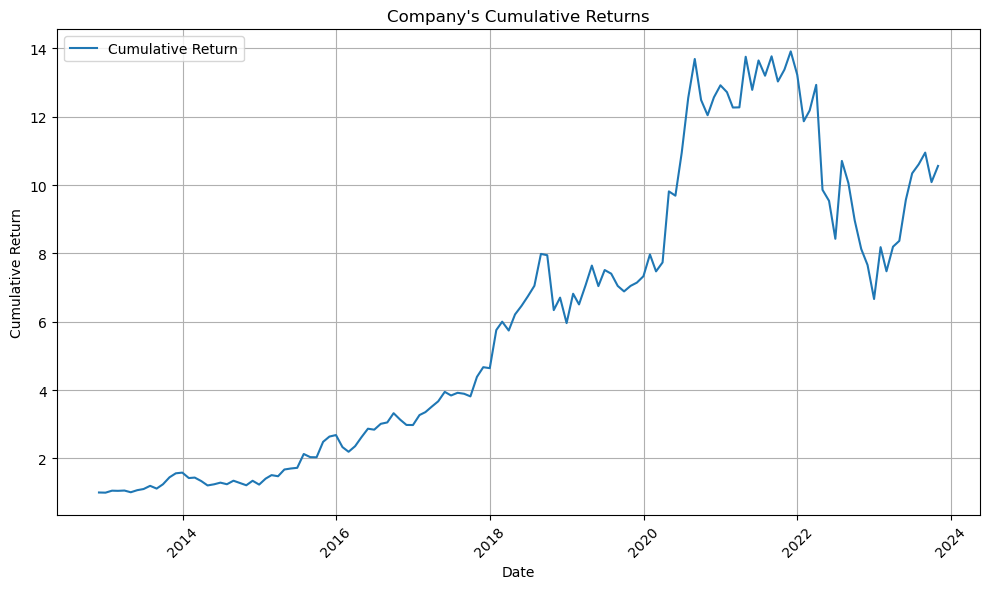

In [26]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming you already have your data in a DataFrame called `out`
# Filter the data for the specific company (e.g., Apple)
comp = out[out['comnam'].str.contains(company_name, case=False)]
comp = comp.sort_values(by='date')

print(comp['stock_return'].describe())
print(comp['stock_return'].max())
print(comp['stock_return'].min())

# Calculate cumulative returns starting at 1
comp['cumulative_return'] = (1 + comp['stock_return']).cumprod()
comp['cumulative_return'] = comp['cumulative_return'] /  comp['cumulative_return'].iloc[0]

# Plot cumulative returns
plt.figure(figsize=(10, 6))
plt.plot(comp['date'], comp['cumulative_return'], label='Cumulative Return')
plt.title("Company's Cumulative Returns")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


## PORTFOLIO

In [27]:
data = out.copy()
sort_criteria = 'b_it'
is_lowest = False # do we want the lowest top percentage according to the sort criteria or the highest (false for highest)
top_percentage = 10
number_of_companies = len(out['gvkey'].unique())
starting_money = 1
start_date = '2009-12-31'
end_date = '2023-12-31'

          date  monthly_return  cumulative_return  snp_monthly_return  \
158 2023-02-28       -0.137895           0.001200           -0.026114   
159 2023-03-31       -0.143515           0.001028            0.035053   
160 2023-04-30       -0.144368           0.000879            0.014643   
161 2023-05-31       -0.007129           0.000873            0.002483   
162 2023-06-30       -0.139270           0.000752            0.064727   
163 2023-07-31       -0.053663           0.000711            0.031139   
164 2023-08-31       -0.151418           0.000604           -0.017717   
165 2023-09-30       -0.173168           0.000499           -0.048720   
166 2023-10-31       -0.172343           0.000413           -0.021980   
167 2023-11-30       -0.051425           0.000392            0.089178   

     snp_cumulative_return  
158               3.623616  
159               3.750635  
160               3.805554  
161               3.815002  
162               4.061935  
163               4.18

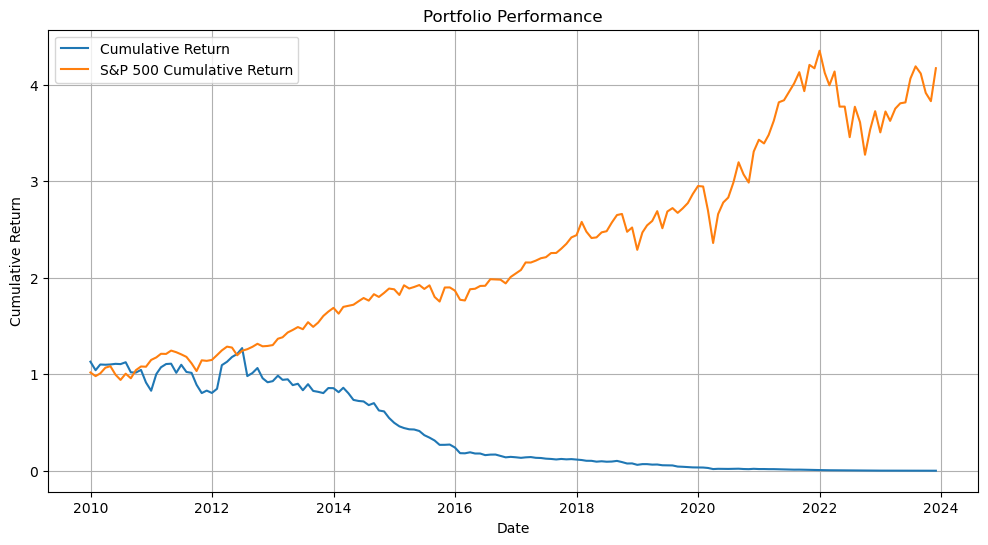

In [28]:
# Preparing the data
data['date'] = pd.to_datetime(data['date'])
data = data[(data['date'] >= start_date) & (data['date'] <= end_date)]

# Get unique months
unique_months = data['date'].sort_values().unique()

# Portfolio simulation
current_money = starting_money
current_snp_money = starting_money
monthly_returns = []

for month in unique_months:
    # Filter data for the current month
    monthly_data = data[data['date'] == month]
    
    # Sort by criteria
    sorted_data = monthly_data.sort_values(by=sort_criteria, ascending=is_lowest)
    
    # Select top percentage of companies
    top_count = max(1, int(len(sorted_data) * top_percentage / 100))
    selected_companies = sorted_data.iloc[:top_count]
    
    # Equal weight per company
    weight = 1 / top_count
    # print(top_count)
    
    # Calculate monthly return for the portfolio
    portfolio_return = (selected_companies['stock_return'] * weight).sum()
    snp_return = selected_companies['snp_return'].mean()

    # Update current money
    current_money = current_money * (1 + portfolio_return)
    current_snp_money = current_snp_money * (1 + snp_return)
    
    # Store monthly return and cumulative return
    monthly_returns.append({
        'date': month,
        'monthly_return': portfolio_return,
        'cumulative_return': current_money / starting_money,
        'snp_monthly_return': snp_return,
        'snp_cumulative_return': current_snp_money / starting_money
    })

# Convert results to a DataFrame
results = pd.DataFrame(monthly_returns)

# Display results
print(results.tail(10))

# Plotting results
plt.figure(figsize=(12, 6))
plt.plot(results['date'], results['cumulative_return'], label='Cumulative Return')
plt.plot(results['date'], results['snp_cumulative_return'], label='S&P 500 Cumulative Return')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.title('Portfolio Performance')
plt.legend()
plt.grid(True)
plt.show()


# Backtesting

Using the cash_hedged_returns as a signal of whether or not to take a position based on 
the previous X (X = lookback_period) months of cash_hedged_return performance. Works.

In [29]:
def backtest_portfolio(inp, lookback_months, signal='cash_hedged_return', return_column='stock_return'):
    """
    Backtests a portfolio strategy based on Point-in-Time data for monthly data.

    Parameters:
    - data: DataFrame with Point-in-Time financial data.
        - Must contain columns: 'date', 'company', signal, price_column.
    - lookback_months: Number of months to look back to calculate positions and weights.
    - signal: The column representing cash-hedged returns for each company.
    - price_column: The column representing stock prices for each company.

    Returns:
    - DataFrame with portfolio returns for each available trading month.
    """

    data = inp.copy()

    data = data.sort_values(['comnam', 'date']).reset_index(drop=True)

    grouped = data.groupby('comnam')

    portfolio_returns = []

    unique_dates = sorted(data['date'].unique())
    for current_date in unique_dates:

        portfolio = []

        for company, group in grouped:
            company_data = group[group['date'] < current_date]
            lookback_data = company_data.tail(lookback_months)

            if len(lookback_data) < lookback_months:
                continue

            signal_performance = lookback_data[signal].mean()
            if signal_performance > 0:
                stock_return = group.loc[group['date'] == current_date, return_column]
                if not stock_return.empty:
                    portfolio.append({
                        'company': company,
                        'weight': signal_performance,
                        'monthly_return': stock_return.values[0]
                    })

        # Normalize weights for the portfolio
        if portfolio:
            portfolio_df = pd.DataFrame(portfolio)
            total_weight = portfolio_df['weight'].sum()
            portfolio_df['normalized_weight'] = portfolio_df['weight'] / total_weight

            # Calculate the portfolio return for the current month
            portfolio_return = (portfolio_df['normalized_weight'] * portfolio_df['monthly_return']).sum()
        else:
            portfolio_return = 0

        # Append portfolio return
        portfolio_returns.append({'date': current_date, f'{signal}_portfolio_return': portfolio_return})

    # Return the portfolio returns as a DataFrame
    portfolio_returns_df = pd.DataFrame(portfolio_returns)
    return portfolio_returns_df

## Optimization of lookback period

This optimzation was run a couple times and averaged an output of 9 for b_it and 3 for cash_hedged_returns for those variables as independent signals. We cannot run it everytime due to computing power/time constraints as well as the fact that it is not scientific to optimize over the testing data - it is only permissable on the training data.

In [30]:
# from scipy.optimize import minimize

# # Objective function to maximize Sharpe Ratio
# def objective(lookback_months, data):
#     lookback_months = int(lookback_months)  # Ensure it's an integer
#     if lookback_months < 1:
#         return -np.inf  # Penalize invalid lookback values
    
#     # Run the backtesting function with the given lookback_months
#     portfolio_returns_df = backtest_portfolio(data, lookback_months)
    
#     # Extract portfolio returns
#     portfolio_returns = portfolio_returns_df['cash_hedged_return_portfolio_return']
    
#     # Avoid invalid calculations
#     if portfolio_returns.empty or portfolio_returns.std() == 0:
#         return -np.inf  # Penalize for lack of variance or empty returns
    
#     # Compute Sharpe Ratio (assuming risk-free rate r_f = 0)
#     sharpe_ratio = portfolio_returns.mean() / portfolio_returns.std()
    
#     # Return negative Sharpe Ratio because we want to maximize it
#     return -sharpe_ratio

# # Bounds for lookback months
# bounds = [(1, 12)]  # Example: 1 to 12 months

# # Optimize lookback_months
# result = minimize(objective, x0=3, args=(out,), bounds=bounds, method='Powell')

# optimal_lookback_months = int(result.x)
# print(f"Optimal Lookback Months: {optimal_lookback_months}")

In [31]:
temp_1 = backtest_portfolio(out, signal='b_it', lookback_months=9)
temp_2 = backtest_portfolio(out, signal='cash_hedged_return', lookback_months=3)

portfolio = pd.merge(temp_1, out[out['permno'] == out['permno'][0]], on='date', how='left')

portfolio = pd.merge(portfolio, temp_2, on='date', how='left')

portfolio = portfolio[['date', 'b_it_portfolio_return', 'cash_hedged_return_portfolio_return', 'snp_return', 'rf_rate']].dropna()

portfolio

,date,b_it_portfolio_return,cash_hedged_return_portfolio_return,snp_return,rf_rate
60,2014-07-31,-0.070979,-0.067126,-0.015080,0.000000
61,2014-08-31,0.005275,0.030786,0.037655,0.000000
62,2014-09-30,-0.044912,-0.055447,-0.015513,0.000000
63,2014-10-31,-0.011374,0.021695,0.023202,0.000000
64,2014-11-30,0.043606,-0.017341,0.024535,0.000000
...,...,...,...,...,...
168,2023-07-31,0.070762,-0.036072,0.031139,0.004409
169,2023-08-31,-0.133499,-0.100124,-0.017717,0.004610
170,2023-09-30,-0.079304,-0.072339,-0.048720,0.004208
171,2023-10-31,-0.198058,0.105003,-0.021980,0.004630


 ## Performance Analysis

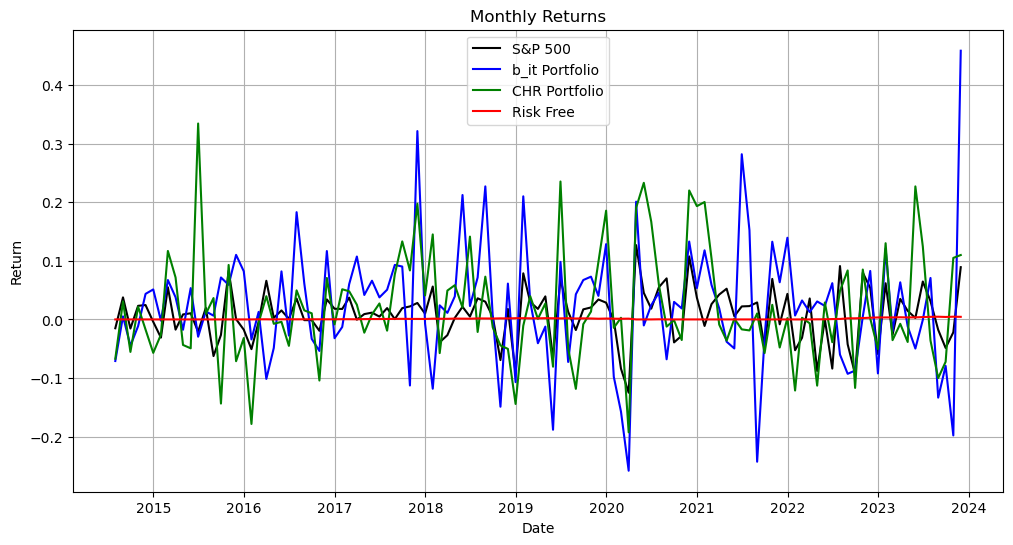

In [32]:
plt.figure(figsize=(12, 6))
plt.plot(portfolio['date'], portfolio['snp_return'], label='S&P 500', color='black')
plt.plot(portfolio['date'], portfolio['b_it_portfolio_return'], label='b_it Portfolio', color='blue')
plt.plot(portfolio['date'], portfolio['cash_hedged_return_portfolio_return'], label='CHR Portfolio', color='green')
plt.plot(portfolio['date'], portfolio['rf_rate'], label='Risk Free', color='red')
plt.title('Monthly Returns')
plt.xlabel('Date')
plt.ylabel('Return')
plt.legend()
plt.grid()
plt.show()

In [33]:
portfolio['log_temp_return'] = np.log1p(portfolio['snp_return'])
portfolio['snp_cum_return'] = np.expm1(portfolio['log_temp_return'].cumsum())

portfolio['log_temp_return'] = np.log1p(portfolio['b_it_portfolio_return'])
portfolio['b_it_portfolio_cum_return'] = np.expm1(portfolio['log_temp_return'].cumsum())

portfolio['log_temp_return'] = np.log1p(portfolio['cash_hedged_return_portfolio_return'])
portfolio['cash_hedged_return_portfolio_cum_return'] = np.expm1(portfolio['log_temp_return'].cumsum())

portfolio['log_temp_return'] = np.log1p(portfolio['rf_rate'])
portfolio['rf_cum_return'] = np.expm1(portfolio['log_temp_return'].cumsum())

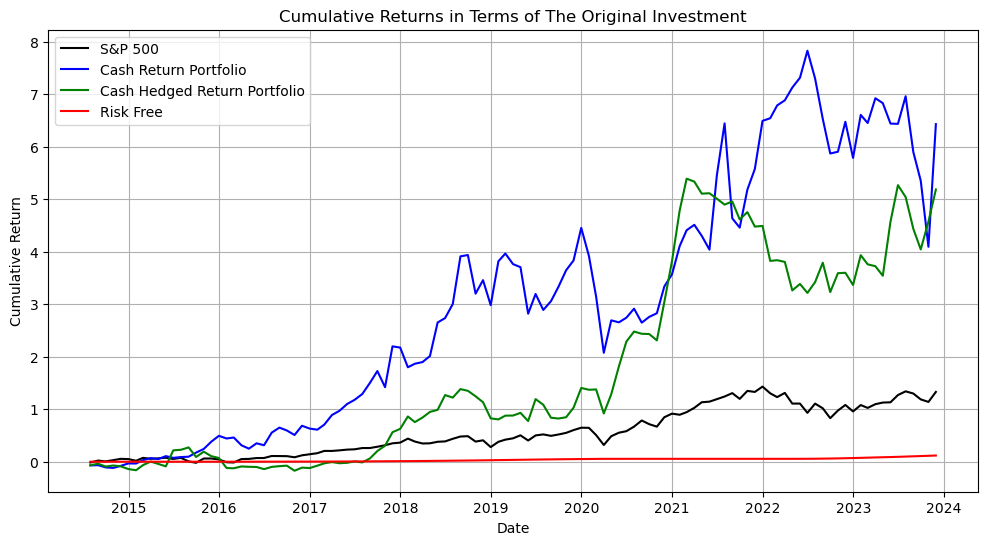

In [34]:
plt.figure(figsize=(12, 6))
plt.plot(portfolio['date'], portfolio['snp_cum_return'], label='S&P 500', color='black')
plt.plot(portfolio['date'], portfolio['b_it_portfolio_cum_return'], label='Cash Return Portfolio', color='blue')
plt.plot(portfolio['date'], portfolio['cash_hedged_return_portfolio_cum_return'], label='Cash Hedged Return Portfolio', color='green')
plt.plot(portfolio['date'], portfolio['rf_cum_return'], label='Risk Free', color='red')
plt.title('Cumulative Returns in Terms of The Original Investment')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid()
plt.show()

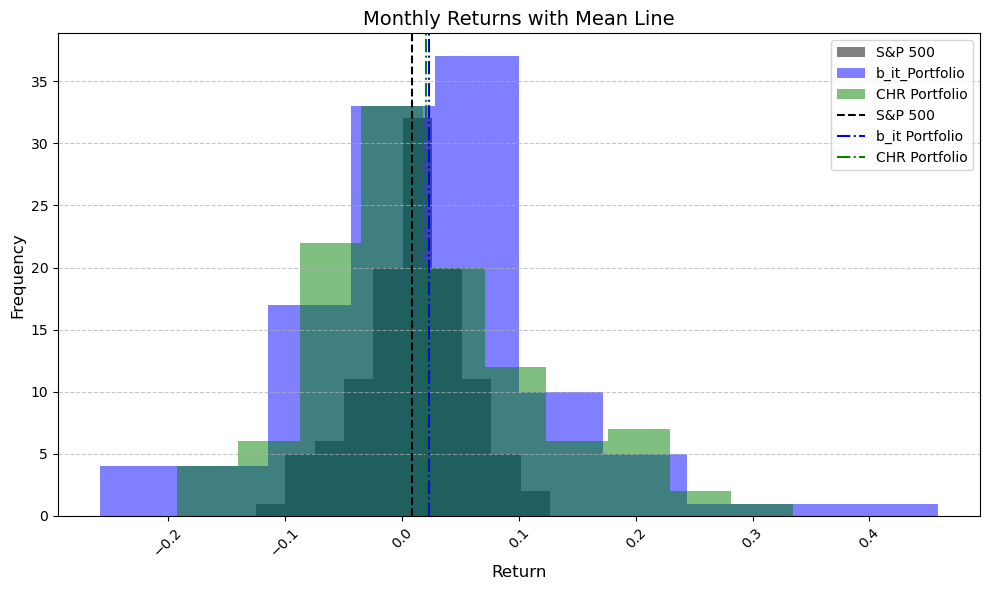

In [35]:
plt.figure(figsize=(10, 6))

plt.hist(portfolio['snp_return'], label='S&P 500', color='black', alpha=0.5)
plt.hist(portfolio['b_it_portfolio_return'], label='b_it_Portfolio', color='blue', alpha=0.5)
plt.hist(portfolio['cash_hedged_return_portfolio_return'], label='CHR Portfolio', color='green', alpha=0.5)

plt.axvline(portfolio["snp_return"].mean(), color="black", linestyle="--", label=f"S&P 500")
plt.axvline(portfolio["b_it_portfolio_return"].mean(), color="blue", linestyle="-.", label=f'b_it Portfolio')
plt.axvline(portfolio["cash_hedged_return_portfolio_return"].mean(), color="green", linestyle="-.", label=f'CHR Portfolio')

plt.title("Monthly Returns with Mean Line", fontsize=14)
plt.xlabel("Return", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.xticks(rotation=45)
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.tight_layout()
#plt.ylim(0, 80)
plt.show()

In [36]:
def sharpe(ret):
    excess_ret = portfolio[f"{ret}"] - portfolio["rf_rate"]
    average_excess_return = excess_ret.mean()
    std_excess_return = excess_ret.std()
    return (average_excess_return / std_excess_return) * np.sqrt(12)

print("ANNUALISED:")

pd.DataFrame(
    [
        ["SNP500" , '{0:.4f}'.format(sharpe('snp_return')), (1 + portfolio['snp_return'].mean()) ** 12 - 1, (1 + (portfolio['snp_return'].std()**2)) ** 12 - 1],
        ["b_it Portfolio" , '{0:.4f}'.format(sharpe('b_it_portfolio_return')), (1 + portfolio['b_it_portfolio_return'].mean()) ** 12 - 1, (1 + (portfolio['b_it_portfolio_return'].std()**2)) ** 12 - 1],
        ["CHR Portfolio" , '{0:.4f}'.format(sharpe('cash_hedged_return_portfolio_return')), (1 + portfolio['cash_hedged_return_portfolio_return'].mean()) ** 12 - 1, (1 + (portfolio['cash_hedged_return_portfolio_return'].std()**2)) ** 12 - 1],
    ],
    columns=['Asset', 'SHARPE', 'Mean Return', 'Volatility']
)

ANNUALISED:


,Asset,SHARPE,Mean Return,Volatility
0,SNP500,0.5827,0.107002,0.024214
1,b_it Portfolio,0.7296,0.317168,0.141954
2,CHR Portfolio,0.7200,0.273708,0.109427


## Correlation Calculation

In [37]:
input_table = out[['date', 'gvkey',  'stock_return', 'b_it', 'cash_hedged_return']]
input_table = input_table.sort_values(by=['date'])
# remove any date where b_it or cash_hedged_return is NaN
input_table = input_table.dropna(subset=['b_it', 'cash_hedged_return', 'stock_return'])
# only keep one row per combination of date and gvkey
input_table = input_table.drop_duplicates(subset=['date', 'gvkey'], keep='first')
len(input_table)
input_table[:5]

,date,gvkey,stock_return,b_it,cash_hedged_return
8519,2009-07-31,029901,0.018460,-0.037931,0.038787
8520,2009-08-31,029901,0.000851,-0.012100,0.005519
8521,2009-09-30,029901,-0.060271,0.020125,-0.089250
8522,2009-10-31,029901,-0.031317,0.044459,-0.058631
8523,2009-11-30,029901,0.007769,0.011214,0.006527


In [38]:
import pandas as pd
import numpy as np
import random

def compute_random_correlations(data, compute_on='stock_return', num_iterations=1000):
    """
    Compute pairwise correlations between two randomly chosen companies over time, 
    based on stock returns or cash returns, a specified number of times.

    Parameters:
    - data (pd.DataFrame): A DataFrame with columns ['date', 'cash_return', 'stock_return', 'gvkey'].
    - compute_on (str): Column to compute correlations on ('stock_return', 'cash_return', or 'cash_hedged_return').
    - num_iterations (int): Number of random pairs to compute correlations for.

    Returns:
    - correlations (list): A list of computed correlation values.
    """

    # Pivot data for the chosen column (stock_return, cash_return, or cash_hedged_return)
    pivot_data = data.pivot(index='date', columns='gvkey', values=compute_on)

    # Drop rows with all NaN values
    pivot_data = pivot_data.dropna(how='all')

    # print(pivot_data)

    # List of unique companies (gvkeys)
    companies = pivot_data.columns.tolist()

    # print(companies)

    # Initialize a list to store correlation results
    correlations = []

    # Perform random pair correlation computation
    for _ in range(num_iterations):
        # Randomly choose two different companies
        company1, company2 = random.sample(companies, 2)

        # Extract their returns
        series1 = pivot_data[company1]
        series2 = pivot_data[company2]

        # print(series1)
        # print(series2)

        # Align the two series by index (date) and drop rows with NaN
        aligned_series = pd.concat([series1, series2], axis=1).dropna()

        # Compute the correlation if there is sufficient data
        if len(aligned_series) > 1:  # Correlation requires at least two data points
            correlation = aligned_series.corr().iloc[0, 1]  # Correlation between company1 and company2
            correlations.append(correlation)

    return correlations

# Compute correlations based on stock returns
stock_correlations = compute_random_correlations(input_table, compute_on='stock_return', num_iterations=10000)
stock_correlations = [c for c in stock_correlations if pd.notnull(c)]
print(len(stock_correlations))

# Compute correlations based on cash returns
cash_correlations = compute_random_correlations(input_table, compute_on='b_it', num_iterations=10000)
cash_correlations = [c for c in cash_correlations if pd.notnull(c)]
print(len(cash_correlations))

# Compute correlations based on cash-hedged returns
cash_hedged_correlations = compute_random_correlations(input_table, compute_on='cash_hedged_return', num_iterations=10000)
cash_hedged_correlations = [c for c in cash_hedged_correlations if pd.notnull(c)]
print(len(cash_hedged_correlations))

# Display summary statistics
print(f"Stock Return Correlation - Mean: {np.mean(stock_correlations):.3f}, Std Dev: {np.std(stock_correlations):.3f}")
print(f"Cash Return Correlation - Mean: {np.mean(cash_correlations):.3f}, Std Dev: {np.std(cash_correlations):.3f}")
print(f"Cash Hedged Return Correlation - Mean: {np.mean(cash_hedged_correlations):.3f}, Std Dev: {np.std(cash_hedged_correlations):.3f}")


9714
9767
9779
Stock Return Correlation - Mean: 0.189, Std Dev: 0.202
Cash Return Correlation - Mean: 0.012, Std Dev: 0.220
Cash Hedged Return Correlation - Mean: 0.123, Std Dev: 0.204


In [39]:
import pandas as pd
import numpy as np

def compute_overall_correlation(data, compute_on='stock_return'):
    """
    Compute the overall average pairwise correlation across all companies based on the specified return type.

    Parameters:
    - data (pd.DataFrame): A DataFrame with columns ['date', 'cash_return', 'stock_return', 'gvkey'].
    - compute_on (str): Column to compute correlations on ('stock_return', 'cash_return', or 'cash_hedged_return').

    Returns:
    - avg_correlation (float): The average pairwise correlation across all companies.
    - std_dev_correlation (float): The standard deviation of the pairwise correlations.
    """

    # Pivot data for the chosen column (stock_return, cash_return, or cash_hedged_return)
    pivot_data = data.pivot(index='date', columns='gvkey', values=compute_on)

    # Drop rows with all NaN values
    pivot_data = pivot_data.dropna(how='all')

    # Compute the pairwise correlation matrix
    correlation_matrix = pivot_data.corr()

    # Extract the upper triangle of the correlation matrix (excluding the diagonal)
    upper_triangle = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))

    # Flatten the upper triangle into a 1D array and drop NaN values
    pairwise_correlations = upper_triangle.unstack().dropna()

    # Compute the mean and standard deviation of the correlations
    avg_correlation = pairwise_correlations.mean()
    std_dev_correlation = pairwise_correlations.std()

    return avg_correlation, std_dev_correlation

# Compute overall correlations for stock returns
stock_avg_corr, stock_std_corr = compute_overall_correlation(input_table, compute_on='stock_return')

# Compute overall correlations for cash returns
cash_avg_corr, cash_std_corr = compute_overall_correlation(input_table, compute_on='b_it')

# Compute overall correlations for cash-hedged returns
cash_hedged_avg_corr, cash_hedged_std_corr = compute_overall_correlation(input_table, compute_on='cash_hedged_return')

# Display summary statistics
print(f"Stock Return Correlation - Mean: {stock_avg_corr:.3f}, Std Dev: {stock_std_corr:.3f}")
print(f"Cash Return Correlation - Mean: {cash_avg_corr:.3f}, Std Dev: {cash_std_corr:.3f}")
print(f"Cash Hedged Return Correlation - Mean: {cash_hedged_avg_corr:.3f}, Std Dev: {cash_hedged_std_corr:.3f}")

Stock Return Correlation - Mean: 0.189, Std Dev: 0.209
Cash Return Correlation - Mean: 0.011, Std Dev: 0.222
Cash Hedged Return Correlation - Mean: 0.122, Std Dev: 0.212


In [40]:
# rename cash_holdings_t_minus_1 to cash_holdings in out
#out = out.rename(columns={'cash_holdings_t_minus_1': 'cash_holdings'})
# get rid of gvkey 012482

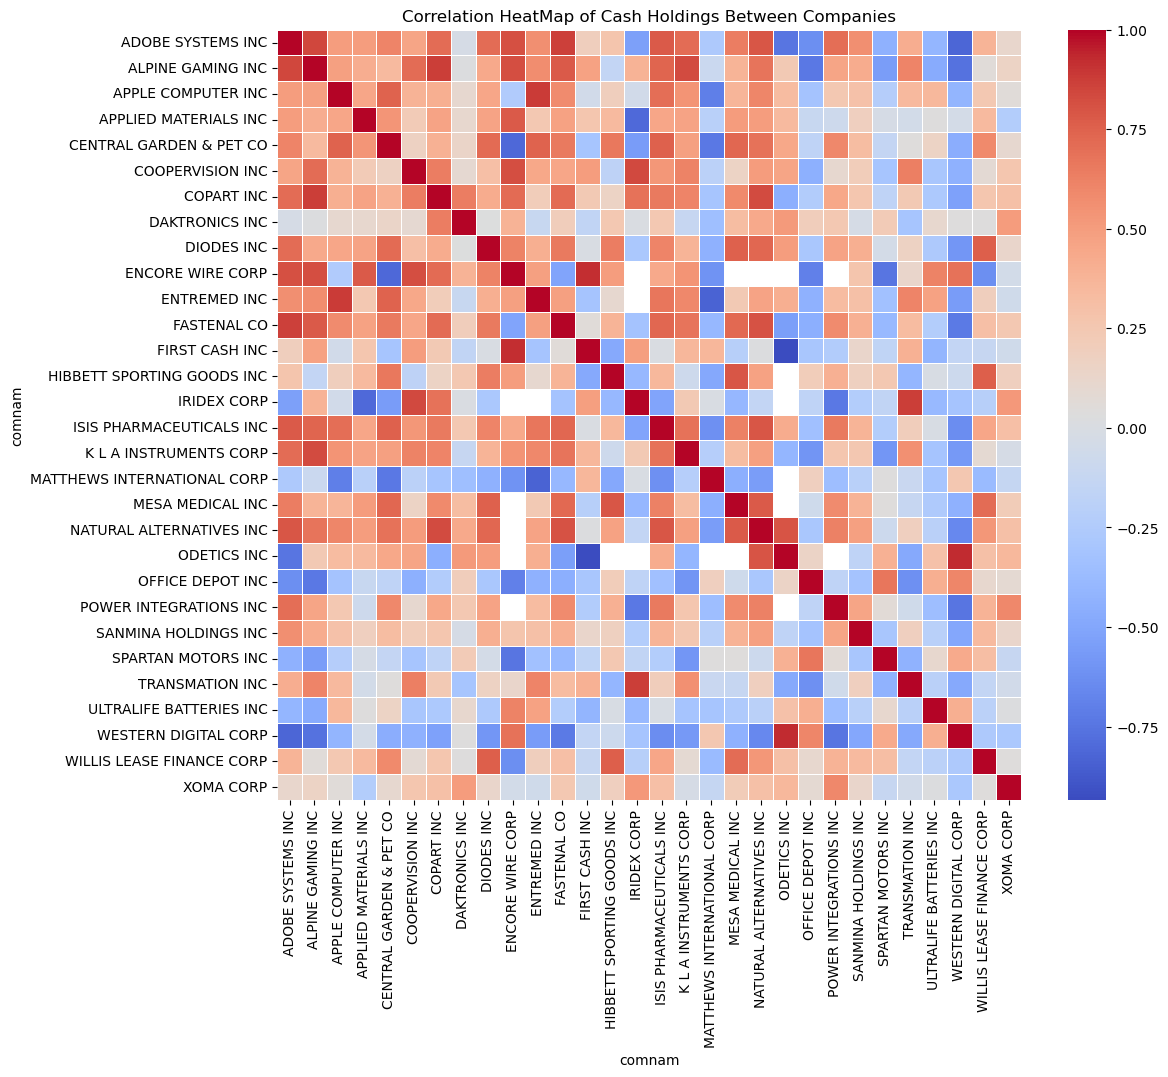

Best Seed: 7
Highest Average Correlation Between Companies: 0.25


In [41]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


# get rid of companies with constant cash holdings from out
df = out.groupby('gvkey').filter(lambda x: x['cash_holdings_t_minus_1'].nunique() > 1)


# Set the number of companies to randomly select
n = 30  # Adjust this as needed

# Initialize variables to store the best result
best_avg_correlation = -np.inf
best_seed = None
best_correlation_matrix = None

# Loop over different random seeds
for seed in range(100):  # Try 100 different random seeds
    # Select n random companies using the current seed
    selected_companies = df['comnam'].drop_duplicates().sample(n=n, random_state=seed).tolist()

    # Filter the DataFrame for the selected companies
    filtered_df = df[df['comnam'].isin(selected_companies)]

    # Create a pivot table where rows are dates, columns are companies, and values are cash_holdings_t_minus_1
    pivot = filtered_df.pivot_table(index='date', columns='comnam', values='cash_holdings_t_minus_1')

    # Compute the correlation matrix
    correlation_matrix = pivot.corr()

    # Calculate the average correlation (excluding self-correlations)
    avg_correlation = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool)).mean().mean()

    # Update the best result if this one is better
    if avg_correlation > best_avg_correlation:
        best_avg_correlation = avg_correlation
        best_seed = seed
        best_correlation_matrix = correlation_matrix

# Plot the heatmap for the best result
plt.figure(figsize=(12, 10))
sns.heatmap(best_correlation_matrix, annot=False, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title(f"Correlation HeatMap of Cash Holdings Between Companies")
plt.show()

# Print the highest average correlation and the seed that achieved it
print(f"Best Seed: {best_seed}")
print(f"Highest Average Correlation Between Companies: {best_avg_correlation:.2f}")


In [42]:
# look at company eltek ltd in out
df[df['comnam'].str.contains('eltek ltd', case=False)]


,date,comnam,gvkey,permno,stock_price,stock_return,b_it,cash_hedged_return,snp_return,rf_rate,company_beta,cash_hedged_beta,cash_holdings_t_minus_1


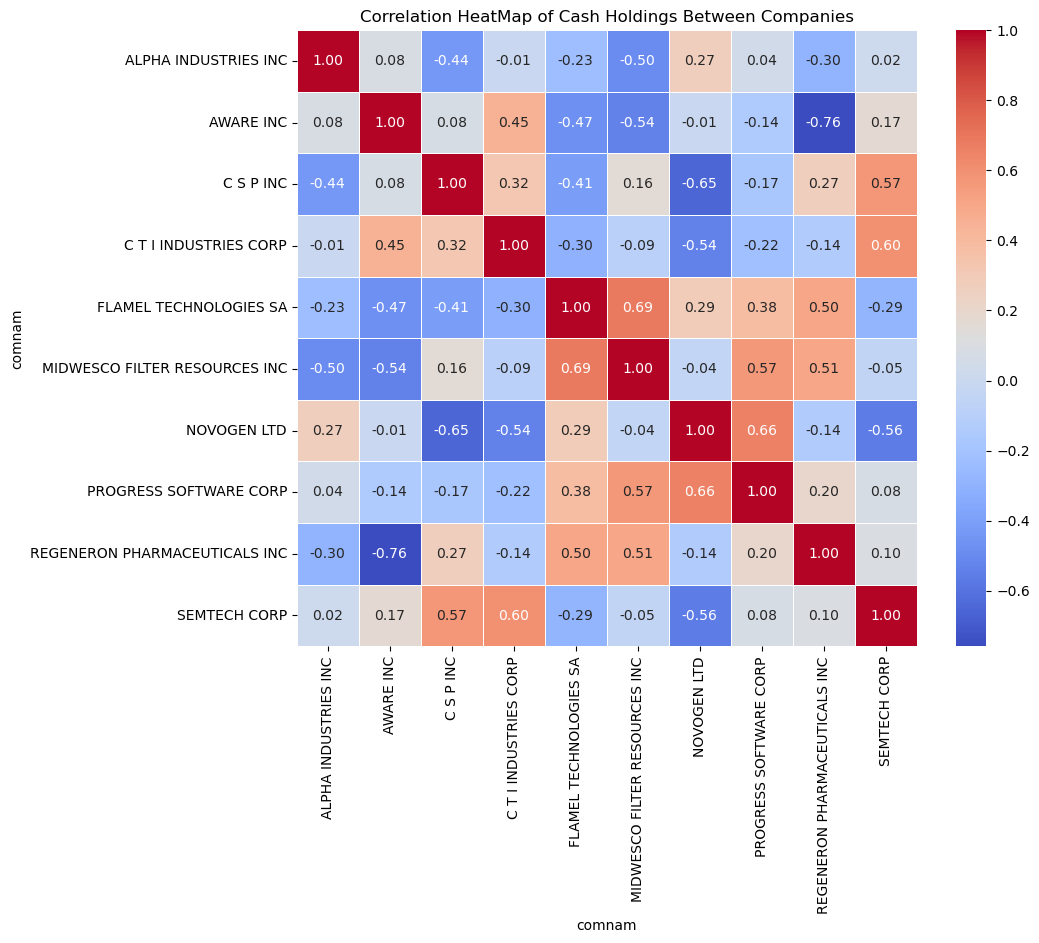

In [43]:
df = out

# Set the number of companies to randomly select
n = 10  # Adjust this as needed

# Select n random companies
selected_companies = df['comnam'].drop_duplicates().sample(n=n, random_state=42).tolist()

# Filter the DataFrame for the selected companies
filtered_df = df[df['comnam'].isin(selected_companies)]

# Create a pivot table where rows are dates, columns are companies, and values are b_it
pivot = filtered_df.pivot_table(index='date', columns='comnam', values='cash_holdings_t_minus_1')

# Compute the correlation matrix
correlation_matrix = pivot.corr()

# Plot the HeatMap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation HeatMap of Cash Holdings Between Companies")
plt.show()


## Backtesting (NEW)

Using the cash_hedged_returns as a signal of whether or not to take a position based on 
the previous X (X = lookback_period) months of cash_hedged_return performance. Works.

In [45]:
def backtest_portfolio(inp, lookback_months, signal='b_it'):
    """
    Backtests a portfolio strategy based on Point-in-Time data for monthly data.

    Parameters:
    - inp: DataFrame with Point-in-Time financial data.
        - Must contain columns: 'date', 'comnam', signal, 'stock_return', 'stock_price'.
    - lookback_months: Number of months to look back to calculate positions and weights.
    - signal: The column representing the performance signal for each company.

    Returns:
    - DataFrame with portfolio returns for each available trading month.
    - DataFrame with portfolio weights for each company and date.
    """
    data = inp.copy()
    data = data.sort_values(['comnam', 'date']).reset_index(drop=True)
    grouped = data.groupby('comnam')

    portfolio_returns = []
    portfolio_weights = []

    unique_dates = sorted(data['date'].unique())

    for current_date in unique_dates:
        portfolio = []

        for company, group in grouped:
            # Get company data up to the current date
            company_data = group[group['date'] < current_date]
            lookback_data = company_data.tail(lookback_months)

            # Skip if there's insufficient lookback data
            if len(lookback_data) < lookback_months:
                continue

            # Calculate the signal's performance over the lookback period
            signal_performance = lookback_data[signal].mean()

            if signal_performance > 0: # threshold
                # Get the return for the following month
                next_month_return = group.loc[group['date'] == current_date, 'stock_return']
                current_price = group.loc[group['date'] == current_date, 'stock_price']
                if not next_month_return.empty and not current_price.empty:
                    portfolio.append({
                        'company': company,
                        'weight': signal_performance,
                        'monthly_return': next_month_return.values[0],
                        'current_price': current_price.values[0]
                    })

        # Normalize weights for the portfolio
        if portfolio:
            portfolio_df = pd.DataFrame(portfolio)
            total_weight = portfolio_df['weight'].sum()
            portfolio_df['normalized_weight'] = portfolio_df['weight'] / total_weight

            # Calculate the portfolio return for the current month
            portfolio_return = (portfolio_df['normalized_weight'] * portfolio_df['monthly_return']).sum()

            # Calculate the portfolio value for the current month
            portfolio_value = (portfolio_df['normalized_weight'] * portfolio_df['current_price']).sum()

            # Store weights for the current portfolio
            for _, row in portfolio_df.iterrows():
                portfolio_weights.append({
                    'entry_date': current_date,
                    'company': row['company'],
                    'weight': row['normalized_weight'],
                    'price': row['current_price'],
                    'following_months_return': row['monthly_return']
                })
        else:
            portfolio_return = 0
            portfolio_value = 0

        # Append the portfolio return and value for the current date
        portfolio_returns.append({
            'entry_date': current_date,
            f'{signal}_portfolio_return': portfolio_return,
            f'{signal}_portfolio_value': portfolio_value
        })

    # Convert portfolio returns and weights to DataFrames
    portfolio_returns_df = pd.DataFrame(portfolio_returns)
    portfolio_weights_df = pd.DataFrame(portfolio_weights)

    return portfolio_returns_df, portfolio_weights_df


## Optimization of lookback period

This optimzation was run a couple times and averaged an output of 7. We cannot run it everytime due to computing power/time constraints as well as the fact that it is not scientific to optimize over the testing data - it is only permissable on the training data.

In [ ]:
# from scipy.optimize import minimize

# signal = 'b_it'

# # Objective function to maximize Sharpe Ratio
# def objective(lookback_months, data):
#     lookback_months = int(lookback_months)  # Ensure it's an integer
#     if lookback_months < 1:
#         return -np.inf  # Penalize invalid lookback values
    
#     # Run the backtesting function with the given lookback_months
#     portfolio_returns_df = backtest_portfolio(data, lookback_months)
    
#     # Extract portfolio returns
#     portfolio_returns = portfolio_returns_df[f'{signal}_portfolio_return']
    
#     # Avoid invalid calculations
#     if portfolio_returns.empty or portfolio_returns.std() == 0:
#         return -np.inf  # Penalize for lack of variance or empty returns
    
#     # Compute Sharpe Ratio (assuming risk-free rate r_f = 0)
#     sharpe_ratio = portfolio_returns.mean() / portfolio_returns.std()
    
#     # Return negative Sharpe Ratio because we want to maximize it
#     return -sharpe_ratio

# # Bounds for lookback months
# bounds = [(1, 12)]  # Example: 1 to 12 months

# # Optimize lookback_months
# result = minimize(objective, x0=3, args=(out,), bounds=bounds, method='Powell')

# optimal_lookback_months = int(result.x)
# print(f"{signal} - optimal Lookback Months: {optimal_lookback_months}")

In [46]:
temp_1, temp_1_details = backtest_portfolio(out, signal='b_it', lookback_months=7)
# temp_2 = backtest_portfolio(out, signal='cash_hedged_return', lookback_months=7)

portfolio = pd.merge(temp_1, out[out['permno'] == out['permno'][0]], right_on='date', left_on='entry_date', how='right')

# portfolio = pd.merge(portfolio, temp_2, on='date', how='left')

portfolio['log_temp_return'] = np.log1p(portfolio['snp_return'])
portfolio['snp_cum_return'] = np.expm1(portfolio['log_temp_return'].cumsum())
portfolio['snp_portfolio_value'] = portfolio['snp_cum_return'] / portfolio['snp_return'][0]

portfolio = portfolio[['entry_date', 'b_it_portfolio_value', 'b_it_portfolio_return', 'snp_return', 'snp_cum_return', 'snp_portfolio_value', 'rf_rate']].dropna()

portfolio

,entry_date,b_it_portfolio_value,b_it_portfolio_return,snp_return,snp_cum_return,snp_portfolio_value,rf_rate
0,2014-07-31,12.851234,-0.123665,-0.015080,-0.015080,1.000000,0.000000
1,2014-08-31,14.520949,0.005274,0.037655,0.022008,-1.459450,0.000000
2,2014-09-30,14.392202,-0.044950,-0.015513,0.006153,-0.408055,0.000000
3,2014-10-31,49.514507,0.018115,0.023202,0.029498,-1.956186,0.000000
4,2014-11-30,51.438159,0.020749,0.024535,0.054757,-3.631233,0.000000
...,...,...,...,...,...,...,...
108,2023-07-31,2.175561,0.071632,0.031139,1.341020,-88.929633,0.004409
109,2023-08-31,4.271200,-0.133811,-0.017717,1.299543,-86.179147,0.004610
110,2023-09-30,3.828459,-0.079389,-0.048720,1.187510,-78.749641,0.004208
111,2023-10-31,3.077280,-0.198455,-0.021980,1.139428,-75.561106,0.004630


In [47]:
temp_1_details

,entry_date,company,weight,price,following_months_return
0,2010-09-30,COPART INC,1.000000,32.970,-0.002419
1,2010-10-31,COPART INC,1.000000,34.225,0.026995
2,2010-11-30,COPART INC,1.000000,35.480,0.047846
3,2010-12-31,COPART INC,1.000000,37.350,0.052706
4,2011-01-31,COPART INC,1.000000,39.250,0.050871
...,...,...,...,...,...
19573,2023-11-30,VIASAT INC,0.009306,20.450,0.109003
19574,2023-11-30,VIDEOTELECOM CORP,0.000859,7.970,-0.057920
19575,2023-11-30,VILLAGE SUPER MARKET INC,0.000001,25.160,0.028197
19576,2023-11-30,ZEBRA TECHNOLOGIES CORP,0.003000,236.980,0.131547


 ## Performance Analysis

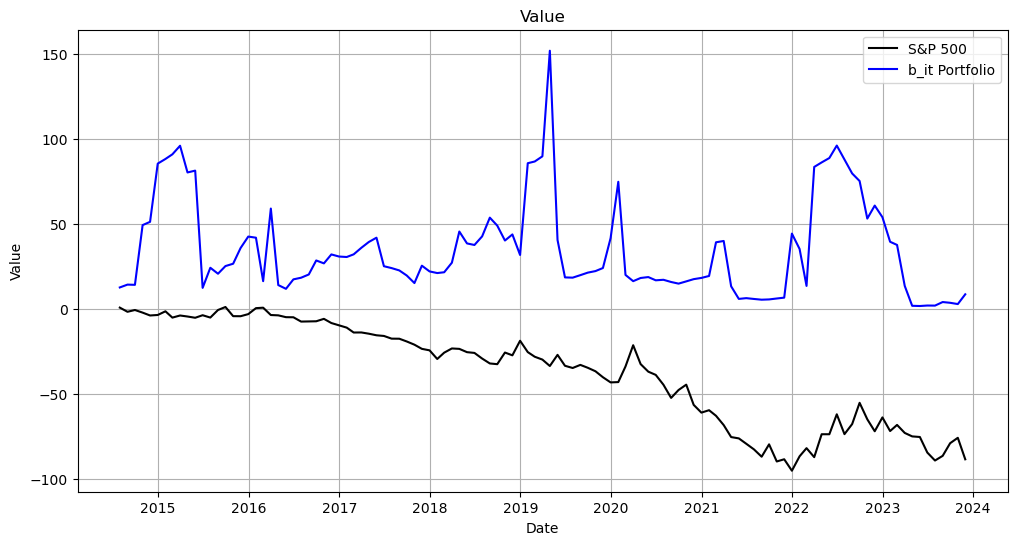

In [48]:
plt.figure(figsize=(12, 6))
plt.plot(portfolio['entry_date'], portfolio['snp_portfolio_value'], label='S&P 500', color='black')
plt.plot(portfolio['entry_date'], portfolio['b_it_portfolio_value'], label='b_it Portfolio', color='blue')
plt.title('Value')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid()
plt.show()

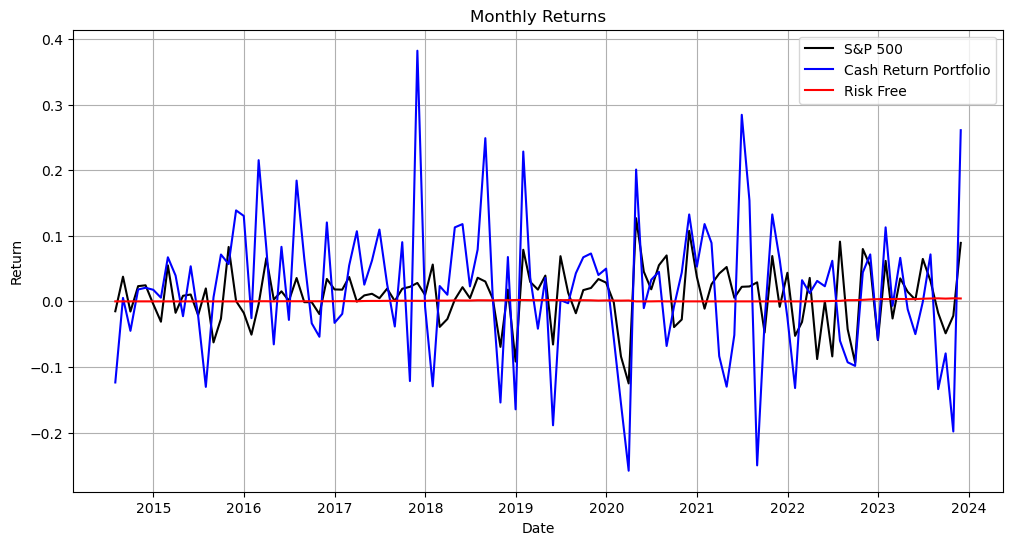

In [72]:
plt.figure(figsize=(12, 6))
plt.plot(portfolio['entry_date'], portfolio['snp_return'], label='S&P 500', color='black')
plt.plot(portfolio['entry_date'], portfolio['b_it_portfolio_return'], label='Cash Return Portfolio', color='blue')
# plt.plot(portfolio['date'], portfolio['cash_hedged_return_portfolio_return'], label='CHR Portfolio', color='green')
plt.plot(portfolio['entry_date'], portfolio['rf_rate'], label='Risk Free', color='red')
plt.title('Monthly Returns')
plt.xlabel('Date')
plt.ylabel('Return')
plt.legend()
plt.grid()
plt.show()

In [50]:
portfolio['log_temp_return'] = np.log1p(portfolio['b_it_portfolio_return'])
portfolio['b_it_portfolio_cum_return'] = np.expm1(portfolio['log_temp_return'].cumsum())

# portfolio['log_temp_return'] = np.log1p(portfolio['cash_hedged_return_portfolio_return'])
# portfolio['cash_hedged_return_portfolio_cum_return'] = np.expm1(portfolio['log_temp_return'].cumsum())

# portfolio['cash_hedged_return_portfolio_cum_return'] = (1 + portfolio['cash_hedged_return_portfolio_return']).cumprod() - 1
# portfolio['b_it_portfolio_cum_return'] = (1 + portfolio['b_it_portfolio_return']).cumprod() - 1

In [65]:
# add 1 to every value in portfolio['b_it_portfolio_cum_return']

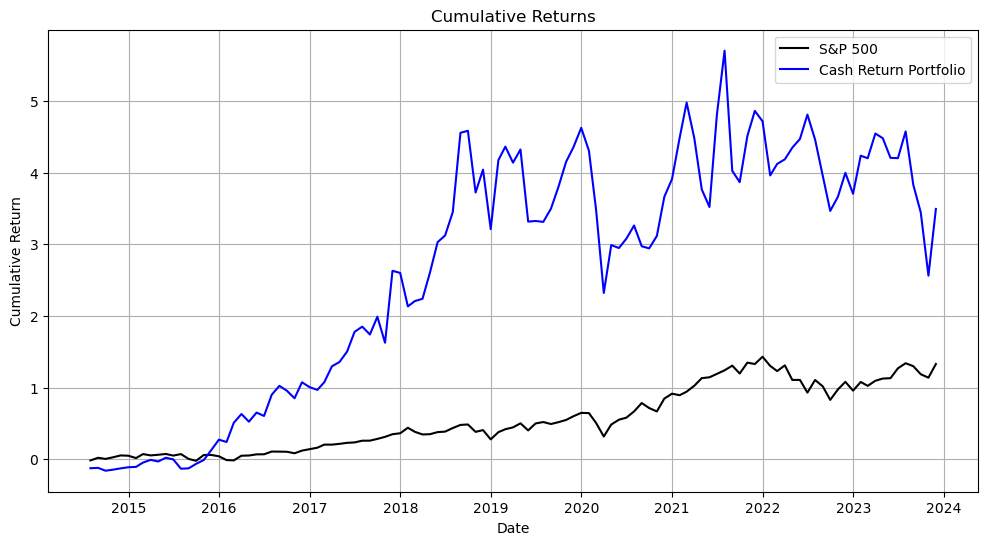

In [58]:
plt.figure(figsize=(12, 6))
plt.plot(portfolio['entry_date'], portfolio['snp_cum_return'], label='S&P 500', color='black')
plt.plot(portfolio['entry_date'], portfolio['b_it_portfolio_cum_return'], label='Cash Return Portfolio', color='blue')
plt.title('Cumulative Returns')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid()
plt.show()

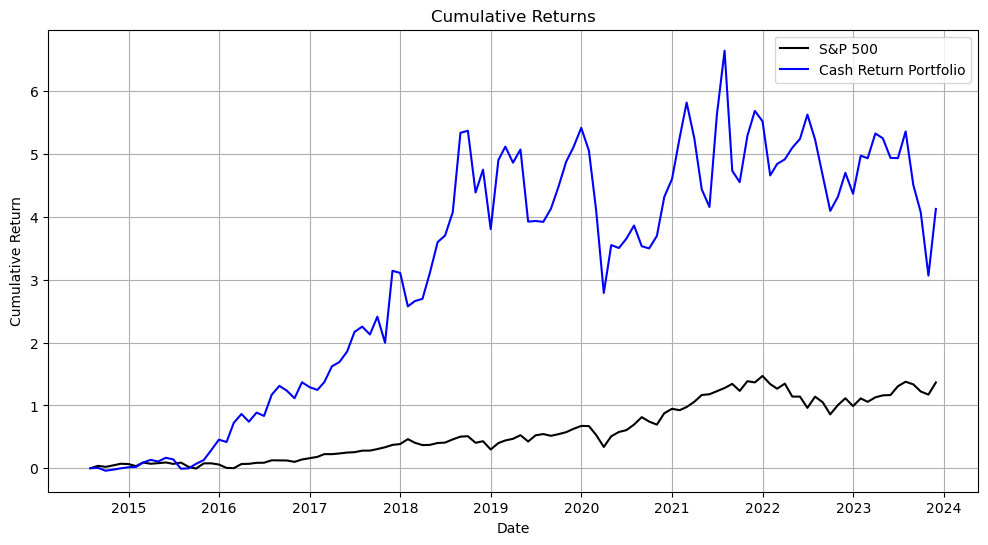

In [67]:
import matplotlib.pyplot as plt

# Assuming the original cumulative return columns are in 'portfolio'
# Add 1 to the returns, normalize to 1 by dividing by the first value, then subtract 1
portfolio['normalized_snp_cum_return'] = (portfolio['snp_cum_return'] + 1) / (portfolio['snp_cum_return'].iloc[0] + 1) - 1
portfolio['normalized_b_it_portfolio_cum_return'] = (portfolio['b_it_portfolio_cum_return'] + 1) / (portfolio['b_it_portfolio_cum_return'].iloc[0] + 1) - 1

# Plot the normalized cumulative returns
plt.figure(figsize=(12, 6))
plt.plot(portfolio['entry_date'], portfolio['normalized_snp_cum_return'], label='S&P 500', color='black')
plt.plot(portfolio['entry_date'], portfolio['normalized_b_it_portfolio_cum_return'], label='Cash Return Portfolio', color='blue')
plt.title('Cumulative Returns')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid()
plt.show()


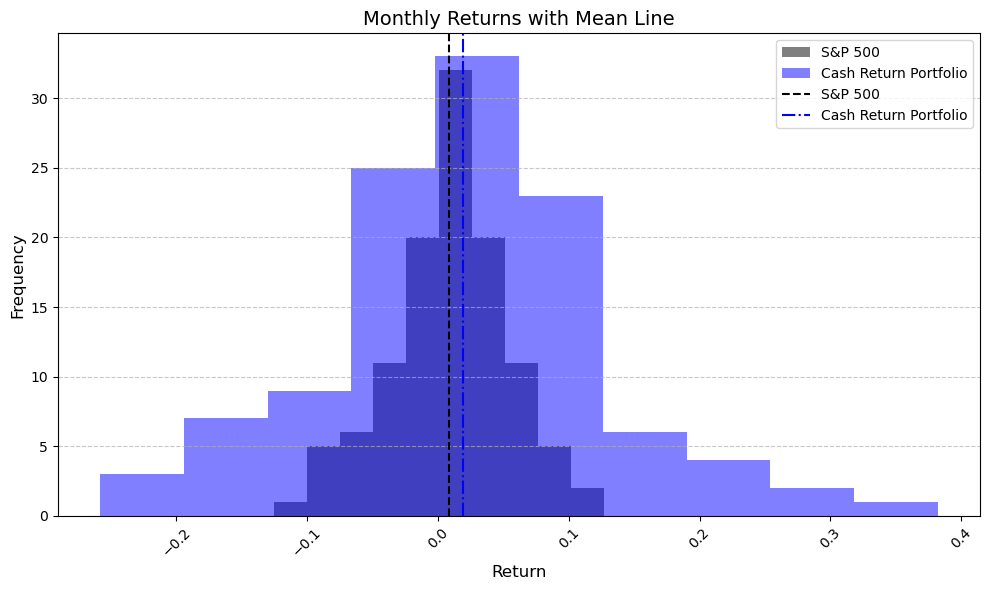

In [71]:
plt.figure(figsize=(10, 6))

plt.hist(portfolio['snp_return'], label='S&P 500', color='black', alpha=0.5)
plt.hist(portfolio['b_it_portfolio_return'], label='Cash Return Portfolio', color='blue', alpha=0.5)
# plt.hist(portfolio['cash_hedged_return_portfolio_return'], label='CHR Portfolio', color='green', alpha=0.5)

plt.axvline(portfolio["snp_return"].mean(), color="black", linestyle="--", label=f"S&P 500")
plt.axvline(portfolio["b_it_portfolio_return"].mean(), color="blue", linestyle="-.", label=f'Cash Return Portfolio')
# plt.axvline(portfolio["cash_hedged_return_portfolio_return"].mean(), color="green", linestyle="-.", label=f'CHR Portfolio')

plt.title("Monthly Returns with Mean Line", fontsize=14)
plt.xlabel("Return", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.xticks(rotation=45)
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.tight_layout()
#plt.ylim(0, 80)
plt.show()

In [69]:
def sharpe(ret):
    excess_ret = portfolio[f"{ret}"] - portfolio["rf_rate"]
    average_excess_return = excess_ret.mean()
    std_excess_return = excess_ret.std()
    return (average_excess_return / std_excess_return) * np.sqrt(12)

print("ANNUALISED:")

pd.DataFrame(
    [
        ["SNP500" , '{0:.4f}'.format(sharpe('snp_return')), (1 + portfolio['snp_return'].mean()) ** 12 - 1, (1 + (portfolio['snp_return'].std()**2)) ** 12 - 1],
        ["Cash Return Portfolio" , '{0:.4f}'.format(sharpe('b_it_portfolio_return')), (1 + portfolio['b_it_portfolio_return'].mean()) ** 12 - 1, (1 + (portfolio['b_it_portfolio_return'].std()**2)) ** 12 - 1]
        # ["CHR Portfolio" , '{0:.4f}'.format(sharpe('cash_hedged_return_portfolio_return')), (1 + portfolio['cash_hedged_return_portfolio_return'].mean()) ** 12 - 1, (1 + (portfolio['cash_hedged_return_portfolio_return'].std()**2)) ** 12 - 1],
    ],
    columns=['Asset', 'SHARPE', 'Mean Return', 'Volatility']
)

ANNUALISED:


,Asset,SHARPE,Mean Return,Volatility
0,SNP500,0.5827,0.107002,0.024214
1,Cash Return Portfolio,0.5829,0.252202,0.144738
